# DDoS attacks detection and characterization

First, we need to import the necessary libraries.

In [1]:
# import needed python libraries

%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Data exploration and pre-processing
Now, we load the dataset from the .csv file provided.

In [2]:
# Load the dataset
df = pd.read_csv("ddos_dataset.csv", header=0, index_col=0, engine='python')

# Remove leading and trailing spaces from column names
df.columns = df.columns.str.strip()

df


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,label
0,172.16.0.5-192.168.50.1-634-60495-17,172.16.0.5,634,192.168.50.1,60495,17,2018-12-01 10:51:39.813448,28415,97,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
1,172.16.0.5-192.168.50.1-60495-634-17,192.168.50.1,634,172.16.0.5,60495,17,2018-12-01 10:51:39.820842,2,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,ddos_dns
2,172.16.0.5-192.168.50.1-634-46391-17,172.16.0.5,634,192.168.50.1,46391,17,2018-12-01 10:51:39.852499,48549,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
3,172.16.0.5-192.168.50.1-634-11894-17,172.16.0.5,634,192.168.50.1,11894,17,2018-12-01 10:51:39.890213,48337,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
4,172.16.0.5-192.168.50.1-634-27878-17,172.16.0.5,634,192.168.50.1,27878,17,2018-12-01 10:51:39.941151,32026,200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65995,172.16.0.5-192.168.50.1-38625-63051-17,172.16.0.5,38625,192.168.50.1,63051,17,2018-12-01 13:04:46.628249,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
65996,172.16.0.5-192.168.50.1-58632-18963-17,172.16.0.5,58632,192.168.50.1,18963,17,2018-12-01 13:04:46.628963,212238,6,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
65997,172.16.0.5-192.168.50.1-46104-64704-17,172.16.0.5,46104,192.168.50.1,64704,17,2018-12-01 13:04:46.629014,1,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag
65998,172.16.0.5-192.168.50.1-60686-10440-17,172.16.0.5,60686,192.168.50.1,10440,17,2018-12-01 13:04:46.629016,108952,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,ddos_udp_lag


### 1.3.1 Correlation analysis
In order to analyze the correlation, we need to compute the correlation between each pair of features, which can be done using the pandas function ``.corr()`` (<a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html?highlight=corr#pandas.DataFrame.corr">documentation</a>). It calculate the Pearson correlation coefficient (<a href="https://en.wikipedia.org/wiki/Pearson_correlation_coefficient">Wiki</a>) between two numerical features, which is a value between -1 and 1. Normally, we take the absolute value, and the closer to 1 the higher the correlation.
$$ r = \frac{n(\sum xy) - (\sum x)(\sum y)}{\sqrt{[n\sum x^2 - (\sum x)^2][n\sum y^2 - (\sum y)^2]}} $$
<!-- $$ r = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2} \sqrt{\sum (y_i - \bar{y})^2}} $$ -->
The result of correlation analysis can be displayed in a heatmap (<a href="https://seaborn.pydata.org/generated/seaborn.heatmap.html">documentation</a>), which is a symmetric matrix, indicating the correlation coefficient between each pair of features (even a feature with itself).

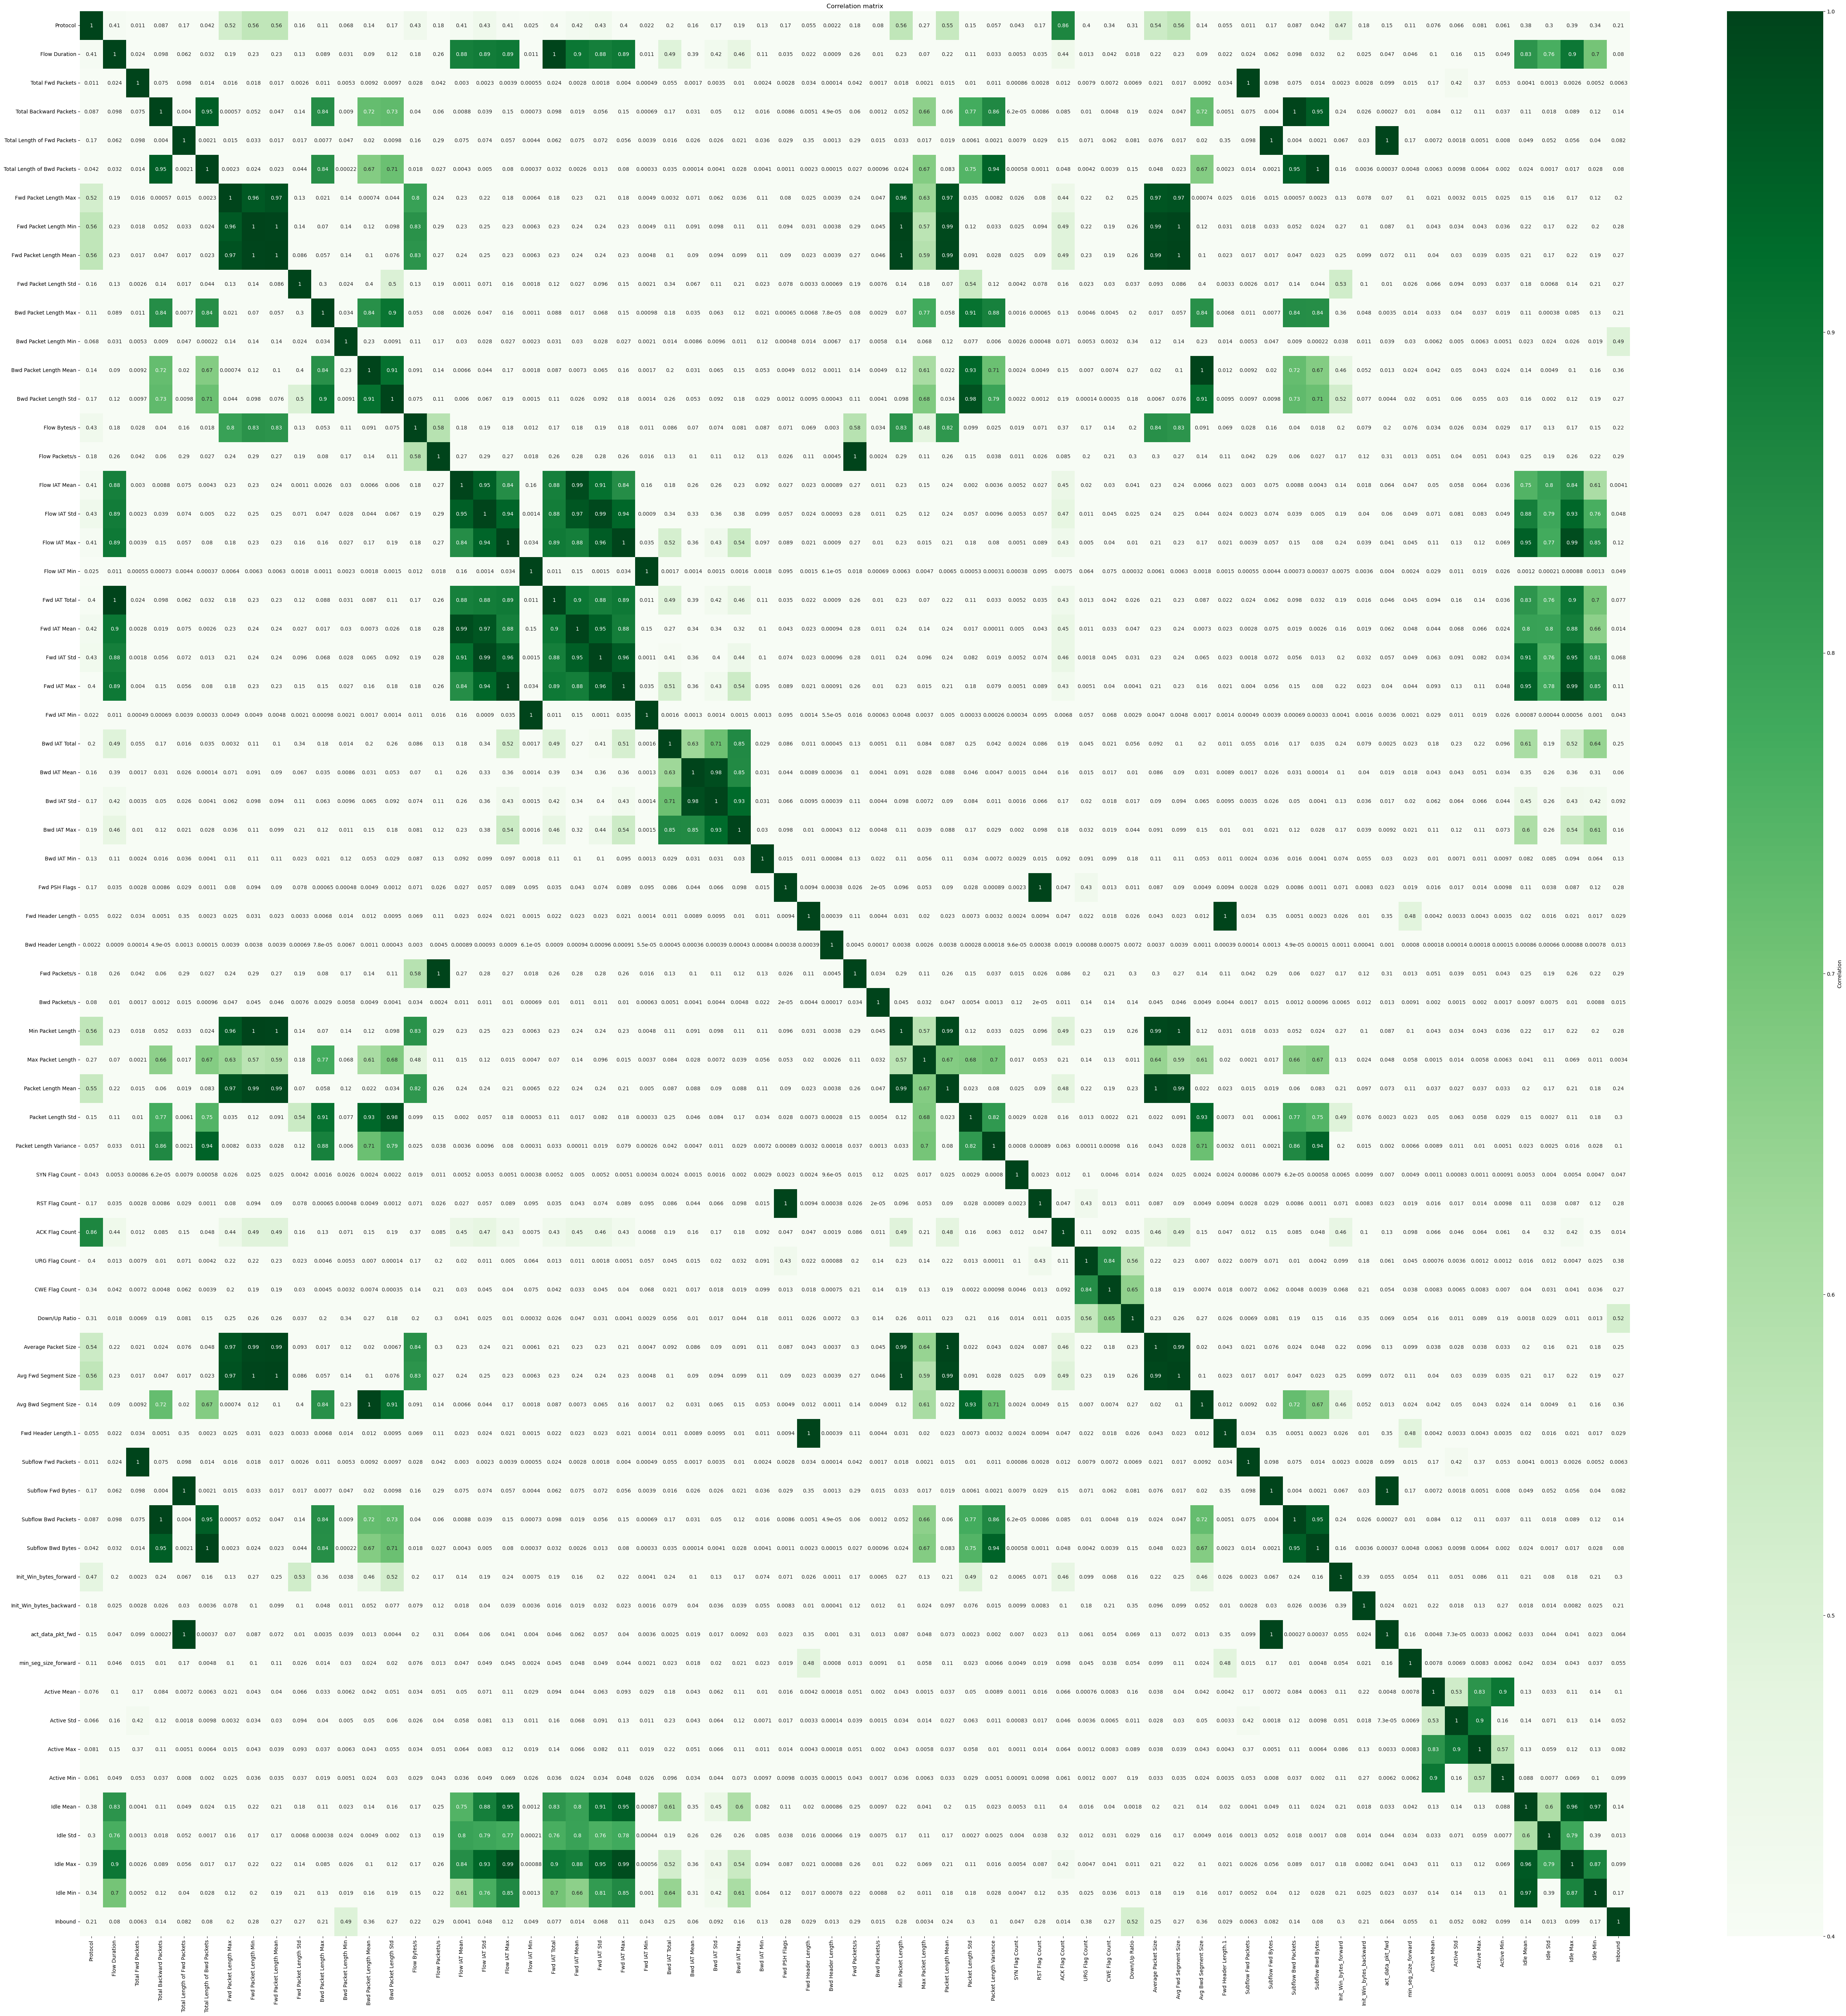

Original dataset: (64239, 87)
Cleaned dataset: (64239, 79)


In [3]:
# Select the numerical and categorical features
categorical_features = df.select_dtypes(exclude=['number']).columns.tolist()
categorical_features.append('Source Port')
categorical_features.append('Destination Port')
numerical_features = [col for col in df.columns if col not in categorical_features]

# Verifica e conversione forzata a numerico (ignorando errori di conversione)
df_clean = df[numerical_features].apply(pd.to_numeric, errors='coerce')

# Calcolo della varianza per identificare le feature valide (con varianza maggiore di 0)
df_filtered = df_clean.loc[:, df_clean.var() > 0]       # poiché queste feature non contribuiscono alla correlazione e possono introdurre rumore

# Compute the correlation matrix
correlation_matrix = df_filtered.corr().abs()
#correlation_matrix = df.drop(columns=categorical_features).corr().abs()    # we take the absolute value to focus on the strength of the correlation

# Compute the heatmap (correlation matrix)
plt.figure(figsize=(len(correlation_matrix.columns), len(correlation_matrix.columns)))
sns.heatmap(correlation_matrix, cmap='Greens', annot=True, vmin=0.4, vmax=1, cbar_kws={'label':'Correlation'})      # we show the correlation when it is > 0.4
plt.title('Correlation matrix')
plt.show()

print("Original dataset:", df.shape)
print("Cleaned dataset:", df_clean.shape)

### Principal Component Analysis (PCA)
Use a number components where you meet the elbow point. i.e., if increasing the number of components does not increase much the cumulative explained variance. Remember: it is essential to perform data standardization before performing PCA.

<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
/var/folders/0j/7hqbq94s1cx1wwg493v81ggr0000gn/T/ipykernel_2596/1904409409.py:27: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'{PC_number} PCs explain {round(perc_cumul_exp_var[PC_number-1], 2)}% of $\sigma^2$')        # round(perc_cumul_exp_var[x], 2) calculates the percentage explained by the first x PCs


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


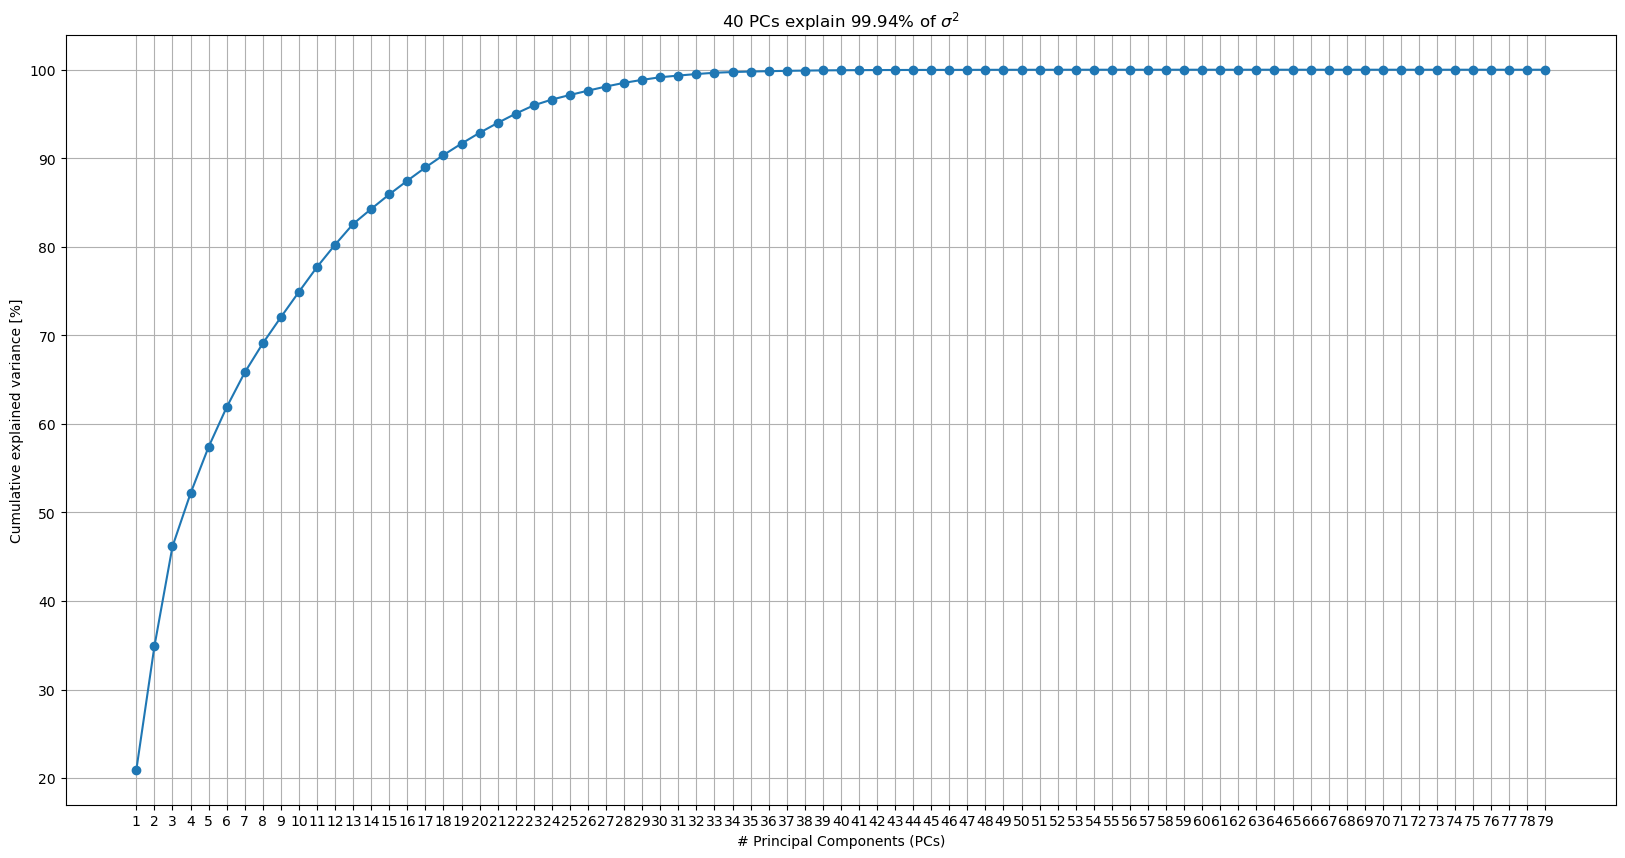

In [4]:
# Create a copy of the original dataset
df_copy = df.copy()

# Data standardization
scaler = StandardScaler()
df_copy[numerical_features] = scaler.fit_transform(df_copy[numerical_features])

pca = PCA(random_state=42)      # PCA must be initialized with a random state to initialize the space
pca.fit(df_copy[numerical_features].dropna())   # compute the new dimensions with number of features from 1 to the number of original features
                                                # .dropna() is for deleting NaN values


explained_variance = pca.explained_variance_ratio_      # describe how much of the dataset variability is indicated by a given amount of features
cumul_exp_var = np.cumsum(explained_variance)       # evaluate the total dataset variability while increasing the variables
perc_cumul_exp_var = cumul_exp_var * 100        # percentage value to better understand the best number of components

# Set the number of PC to take
PC_number = 40

# Make the plot of cumulative explained variance with respect to number of components
plt.figure(figsize=(20,10))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(len(numerical_features))], [i for i in range(1,len(numerical_features)+1)])
plt.grid()
plt.title(f'{PC_number} PCs explain {round(perc_cumul_exp_var[PC_number-1], 2)}% of $\sigma^2$')        # round(perc_cumul_exp_var[x], 2) calculates the percentage explained by the first x PCs
plt.show()



### PCA transformation

In [5]:
# initialize the PCA with the best number of components, in this case, it's 40
pca = PCA(n_components=40, random_state=42)

# fit the data to new space
pca.fit(df_copy[numerical_features])        # it determines the directions along which the data varies the most

# transform the original data into PCA components
pca_result = pca.transform(df_copy[numerical_features])

# create the new dataset
new_columns = [f'PC{i}' for i in range(1, PC_number+1)]
df_pca = pd.DataFrame(pca_result, columns=new_columns)           # pd.DataFrame(...): crea un nuovo DataFrame con i dati trasformati, utilizzando le colonne denominate 'component_1', 'component_2', e 'component_3'

df_pca['label'] = df['label']

df_pca


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,label
0,-0.326972,-0.568036,-1.335202,2.932836,-0.400610,0.112849,-0.005629,-0.300577,-0.665765,1.406859,...,0.076883,-0.013819,0.010736,0.016461,0.003262,-0.007899,-0.000354,0.004932,0.002097,ddos_dns
1,-0.334998,-0.237520,-1.118689,-0.494902,0.370121,0.500121,0.096377,-0.174362,-0.152401,0.362491,...,-0.317497,-0.108334,0.128364,-0.051564,-0.057845,0.050530,0.028872,-0.030207,-0.007127,ddos_dns
2,-0.382483,-0.626580,-1.665222,5.908193,-0.617781,0.338849,-0.045352,-0.189072,-0.910666,2.133400,...,-0.014397,0.029902,0.007163,0.013400,0.006709,0.001471,0.018490,0.011335,-0.006507,ddos_dns
3,-0.382648,-0.626570,-1.665322,5.908177,-0.617755,0.338846,-0.045304,-0.189059,-0.910659,2.133405,...,-0.014397,0.029950,0.007187,0.013648,0.006553,0.001501,0.018454,0.011352,-0.006630,ddos_dns
4,-0.383827,-0.626380,-1.665094,5.907148,-0.617760,0.338134,-0.044401,-0.187899,-0.910231,2.132473,...,-0.014505,0.030388,0.007239,0.013957,0.006368,0.001576,0.018454,0.011295,-0.006611,ddos_dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64234,-0.780513,-0.474958,-0.650200,-0.772041,-0.322952,-0.876117,0.783766,0.689203,-0.082991,-0.169567,...,-0.142122,0.057908,0.011013,0.010873,0.013838,-0.002766,0.007520,-0.001142,0.001902,ddos_udp_lag
64235,-0.010926,-0.493677,-1.328273,0.273601,-0.198798,-0.089609,0.177204,-0.440375,-0.208230,0.831535,...,0.233916,-0.091880,0.006927,-0.039755,-0.037589,0.007713,-0.013050,-0.002035,-0.003578,ddos_udp_lag
64236,-0.780513,-0.474958,-0.650200,-0.772041,-0.322952,-0.876117,0.783766,0.689203,-0.082991,-0.169567,...,-0.142122,0.057908,0.011013,0.010873,0.013838,-0.002766,0.007520,-0.001142,0.001902,ddos_udp_lag
64237,-0.034840,-0.485629,-1.291410,0.226673,-0.191534,-0.085934,0.167342,-0.445269,-0.211506,0.816821,...,0.224750,-0.085257,0.007287,-0.040161,-0.034471,0.005527,-0.013829,-0.000901,-0.004776,ddos_udp_lag


### Loading score
The loading score can be used to extract the coefficients of the linear combination of the original variables from which the principal components (PCs) are constructed. It can describe how strongly a component describes the original features and identify potentially redundant features in for a given component. Note that the score is computed as ``pca.components_.T * np.sqrt(pca.explained_variance_)``.

<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/var/folders/0j/7hqbq94s1cx1wwg493v81ggr0000gn/T/ipykernel_2596/1816972248.py:20: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f'{PC_number} PCs explain {round(perc_cumul_exp_var[PC_number-1], 2)}% of $\sigma^2$')


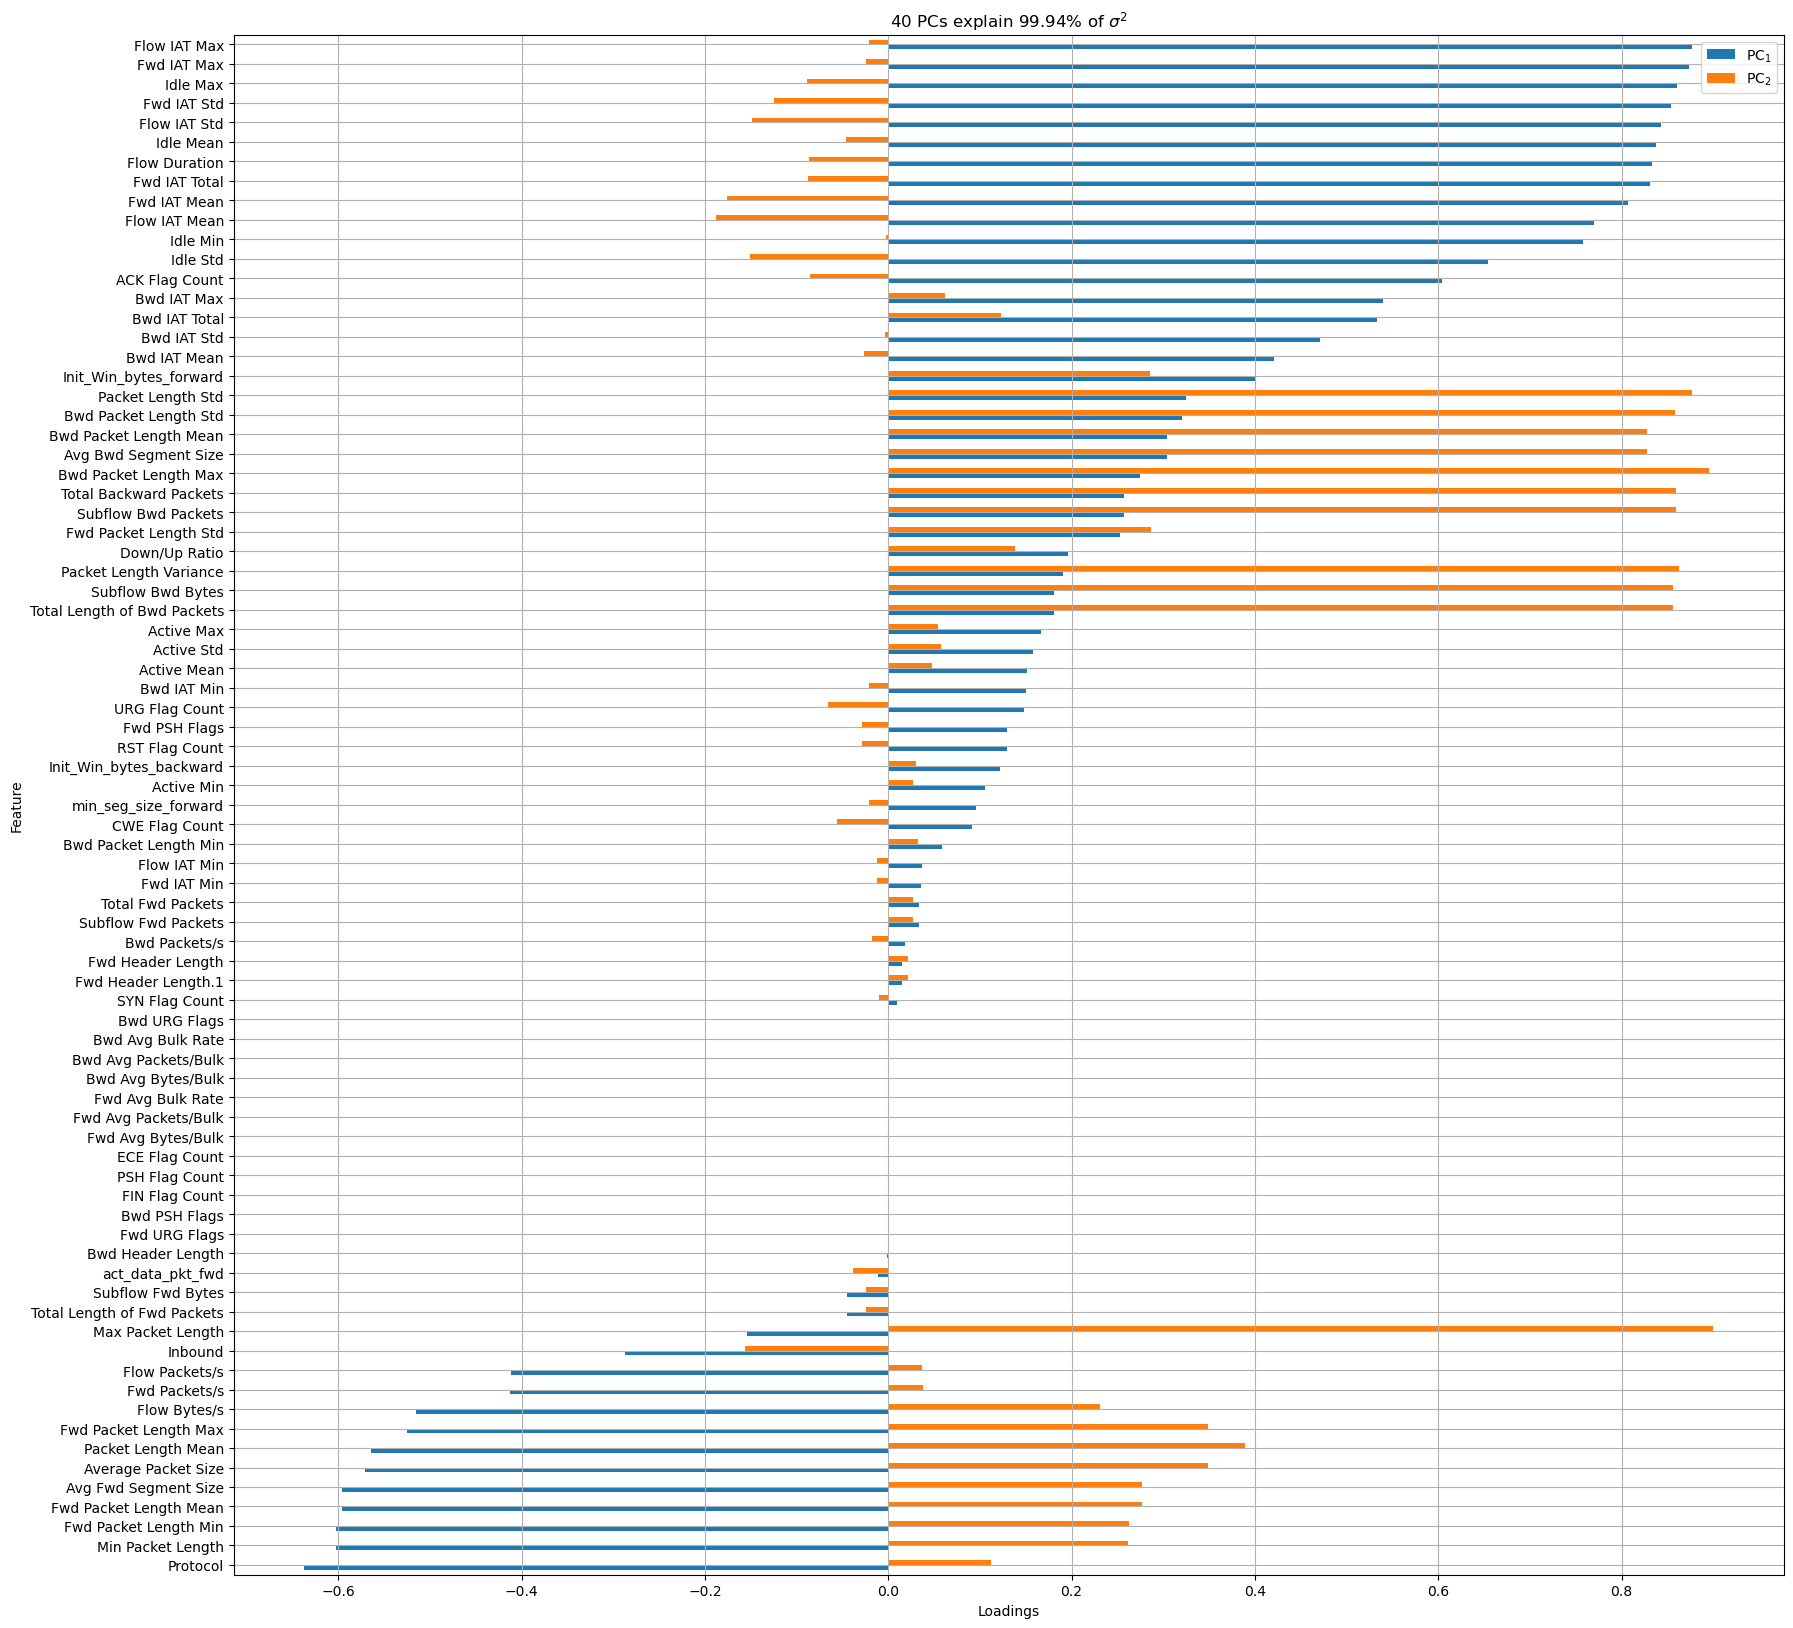

In [6]:
# NOTA: i loading scores rappresentano il contributo di ciascuna feature originale a ciascun componente principale.
# Un loading score alto (sia positivo che negativo) indica che quella particolare feature contribuisce fortemente
# alla direzione di quel componente principale.
# Questi punteggi aiutano a capire quali variabili originali influenzano maggiormente ciascun componente principale,
# fornendo così informazioni sulle caratteristiche principali che descrivono i dati ridotti.

# Compute the loading scores and create the dataframe
loadings = pd.DataFrame(
    data = pca.components_.T * np.sqrt(pca.explained_variance_),
    columns = new_columns,
    index = numerical_features
)

plt.figure(figsize=(20,20))
loadings = loadings[['PC1', 'PC2']]     # seleziona solo i loading scores per i primi due componenti principali
loadings.sort_values(['PC1', 'PC2']).rename(columns={'PC1':'PC$_{1}$', 'PC2':'PC$_{2}$'}).plot.barh(ax=plt.gca())
plt.grid()
plt.xlabel('Loadings')
plt.ylabel('Feature')
plt.title(f'{PC_number} PCs explain {round(perc_cumul_exp_var[PC_number-1], 2)}% of $\sigma^2$')
plt.show()


### 1.3.2 Label encoding
Use One-Hot Encoding for supervised multiclass classification, since supervised machine learning models cannot directly interpret categorical features.

In [7]:
# One-Hot Encoding for the 'label' column
encoded_df = pd.get_dummies(df['label'], prefix='label')    # transform each unique value of the label column into a separate binary column
df_encoded = pd.concat([df, encoded_df], axis=1)        # add the new binary columns to the original dataframe
df_encoded.drop(columns=['label'], inplace=True)        # remove the original label column, as it has been replaced by binary columns


# Set Pandas to show all columns
pd.set_option('display.max_columns', None)

# Display the first rows of the dataset
print(df_encoded.head())

# Restore default limit
pd.reset_option('display.max_columns')

                                Flow ID     Source IP  Source Port  \
0  172.16.0.5-192.168.50.1-634-60495-17    172.16.0.5          634   
1  172.16.0.5-192.168.50.1-60495-634-17  192.168.50.1          634   
2  172.16.0.5-192.168.50.1-634-46391-17    172.16.0.5          634   
3  172.16.0.5-192.168.50.1-634-11894-17    172.16.0.5          634   
4  172.16.0.5-192.168.50.1-634-27878-17    172.16.0.5          634   

  Destination IP  Destination Port  Protocol                   Timestamp  \
0   192.168.50.1             60495        17  2018-12-01 10:51:39.813448   
1     172.16.0.5             60495        17  2018-12-01 10:51:39.820842   
2   192.168.50.1             46391        17  2018-12-01 10:51:39.852499   
3   192.168.50.1             11894        17  2018-12-01 10:51:39.890213   
4   192.168.50.1             27878        17  2018-12-01 10:51:39.941151   

   Flow Duration  Total Fwd Packets  Total Backward Packets  \
0          28415                 97                       0

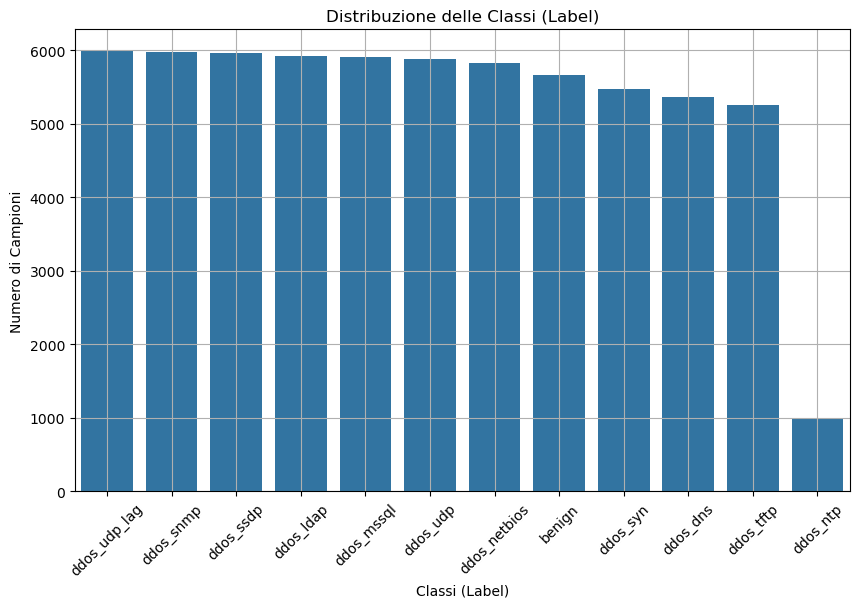

In [8]:
# Conto il numero di campioni per ogni classe
class_counts = df['label'].value_counts()

# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Classi (Label)')
plt.ylabel('Numero di Campioni')
plt.title('Distribuzione delle Classi (Label)')
plt.xticks(rotation=45)
plt.grid()
plt.show()


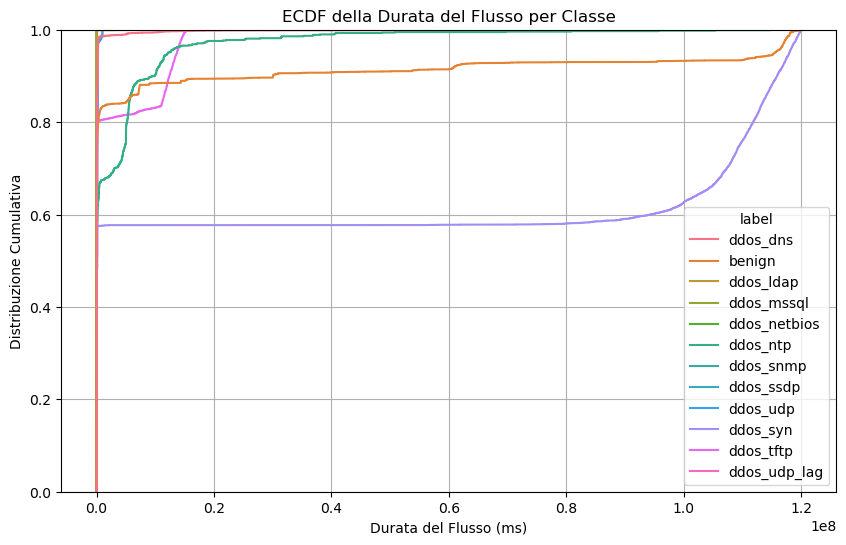

In [9]:
# Obiettivo: Analizzare le differenze nei tempi di flusso tra traffico benigno e attacchi.

# ECDF per la durata del flusso
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df, x='Flow Duration', hue='label')
plt.xlabel('Durata del Flusso (ms)')
plt.ylabel('Distribuzione Cumulativa')
plt.title('ECDF della Durata del Flusso per Classe')
plt.grid()
plt.show()


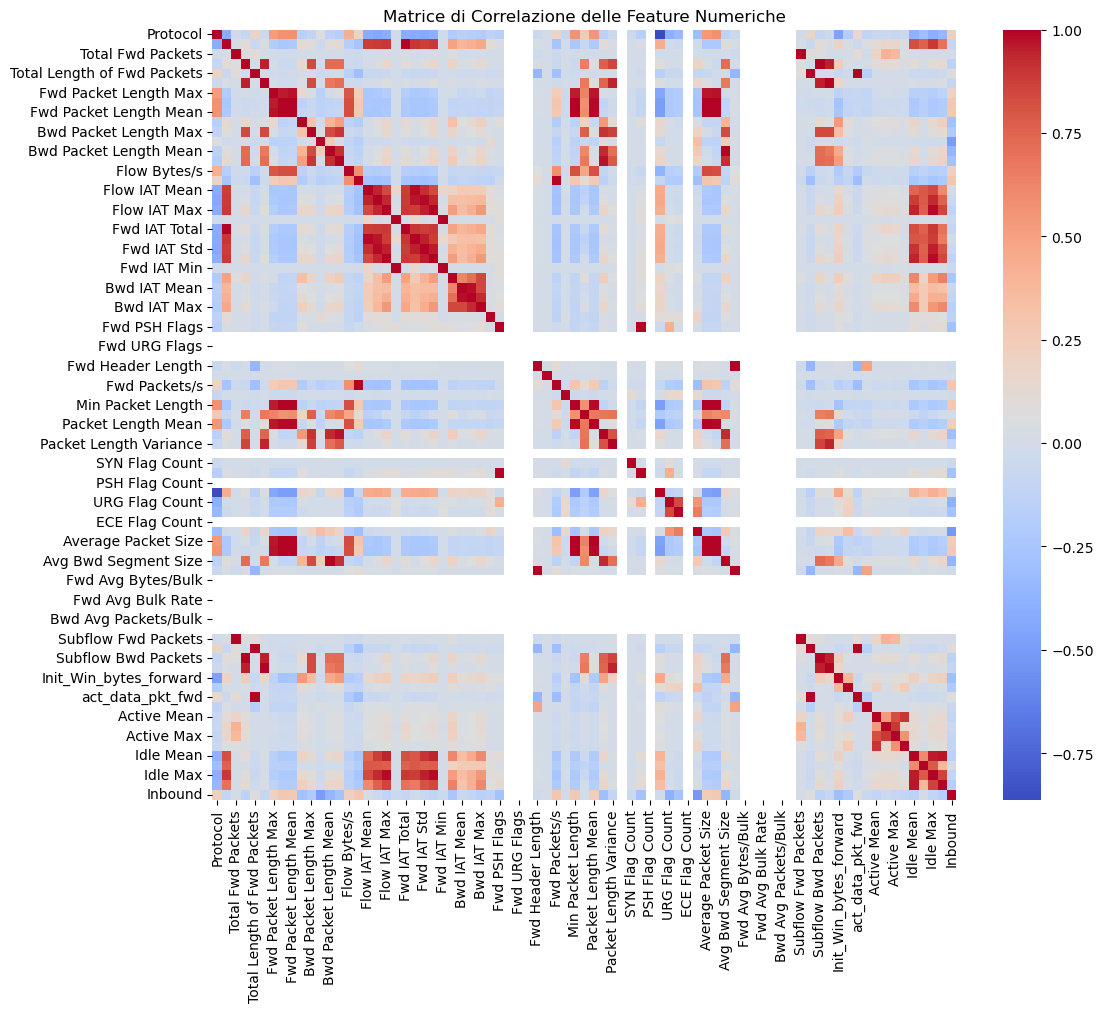

In [10]:
# Obiettivo: Identificare feature altamente correlate che potrebbero essere ridondanti o utili per il clustering

# Calcolo della matrice di correlazione
correlation_matrix = df[numerical_features].corr()

# Heatmap della correlazione
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, cbar=True)
plt.title('Matrice di Correlazione delle Feature Numeriche')
plt.show()


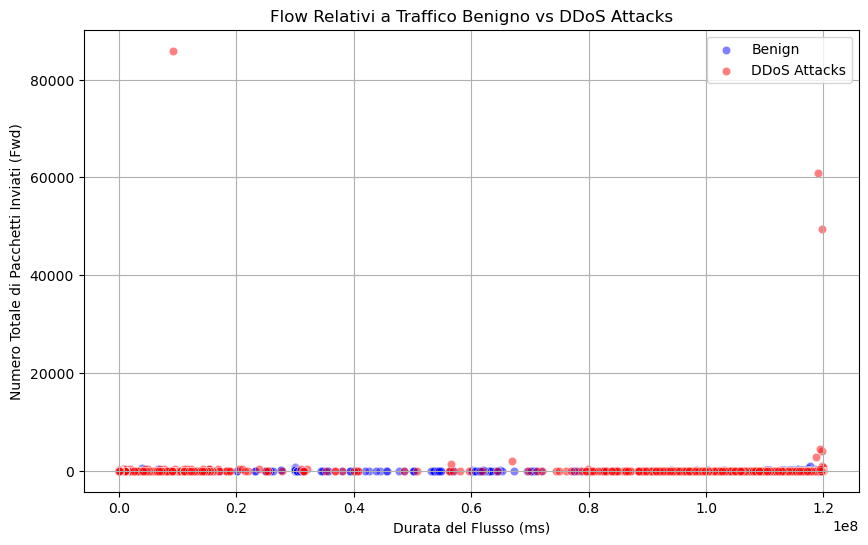

In [26]:
# Creiamo due subset: uno per il traffico benigno e uno per gli attacchi DDoS
benign_df = df[df['label'] == 'benign']
ddos_df = df[df['label'].str.contains('ddos', case=False, na=False)]


# Scatter Plot: utile per visualizzare se esiste una separazione visibile tra traffico benigno e attacchi in base alle feature scelte
plt.figure(figsize=(10, 6))
sns.scatterplot(data=benign_df, x='Flow Duration', y='Total Fwd Packets', label='Benign', alpha=0.5, color='blue')
sns.scatterplot(data=ddos_df, x='Flow Duration', y='Total Fwd Packets', label='DDoS Attacks', alpha=0.5, color='red')
plt.xlabel('Durata del Flusso (ms)')
plt.ylabel('Numero Totale di Pacchetti Inviati (Fwd)')
plt.title('Flow Relativi a Traffico Benigno vs DDoS Attacks')
plt.legend()
plt.grid()
plt.show()
